# Convert to Glove numeric vector (6B-0d) and perform padding

In [1]:
import pandas as pd
path = "df_before_modelling"
df = pd.read_csv(path, index_col=0)

df.text = df.text.astype(str)

/Users/andrewyu/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
def read_glove_vecs(glove_file):
    '''
    This function is to create 3 Dictionaries that can interact with the glove pre-trained weightings
    Input:
        glove_file: the directory of the pre-trained file
    Output:
        words_to_index: A directory that can use words as name and return back the index
        index_to_words: A directory that can use index as name and return back the words
        word_to_vec_map: A directory that can use words as name and directly return the Vector mapping
    '''
    with open(glove_file, 'r', encoding="utf-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [3]:
def sentences_to_indices(X, word_to_index, Tx):
    """
    This function is to converts an array of sentences into an array of indices corresponding to words in the sentences.
    The output shape should match with the embedding dimension.
    
    Input:
        X: array of sentences (strings), of shape (m, 1), i.e. m samples.
        word_to_index: a dictionary called for converting word into index
        Tx: maximum number of words in a sentence. Sentences exceeds this number will be cut 
    
    Returns:
    X_indices: array of indices corresponding to words in the sentences from X, of shape (m, Tx)
    """
    
    m = X.shape[0] # number of data in the dataset
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape 
    X_indices = np.zeros((m, Tx))
    
    for i in range(m):
        sentence_words = X[i].split() #split sentence into a list of word
        sentence_words = sentence_words[0:Tx] # Cut all Words Once it search the maximun lenght Tx
        
        j = 0 # initialize the counter of word in every sentence
        
        for w in sentence_words: # convert word into index and input in the (i,j) elements of X_indices
            try: # try to see if the word is in the glove corpus
                X_indices[i, j] = word_to_index[w]
                j = j+1
            except: #if not, skip it and left that (i,j) elements as 0
                j = j+1
    
    return X_indices

In [4]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.astype(int)]
    return Y

In [5]:
import numpy as np
glove_file = "./Raw data/glove.6B.300d.txt"

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(glove_file)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size = 100000, random_state=8762)

X_train_text = X_train.to_numpy()
X_train_indixes = sentences_to_indices(X_train_text, word_to_index, Tx = 50)  

X_test_text = X_test.to_numpy()
X_test_indixes = sentences_to_indices(X_test_text, word_to_index, Tx = 50)  

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Y_oh_train = convert_to_one_hot(y_train, C = 2)
Y_oh_test = convert_to_one_hot(y_test, C = 2)

In [6]:
import keras 
from keras.layers.embeddings import Embedding
from keras import callbacks
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Dense, Input, SimpleRNN, Bidirectional, Dropout, BatchNormalization, LSTM
from matplotlib import pyplot as plt

# initial model:
1 layer bi-directional RNN (64)x2 hidden state followed by a dense layer

In [7]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1    # adding 1 to fit Keras embedding, special requirement for using Keras
    emb_dim = word_to_vec_map["apple"].shape[0]      # get dimensionality pre-trained embedding
    
    # Initialize the embedding matrix 
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # for every word, idx pair in word_to_index dictionary, map it to its vector representation  
    # and store in the emb matrix
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Define Keras embedding layer and set it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)

    # Build the embedding layer instance
    embedding_layer.build((None,)) # None is used for "Dont know how many data, m samples, will be pass through"
    
    # Set the weights of the embedding layer to the embedding matrix
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [9]:
def Initial_model(input_shape, word_to_vec_map, word_to_index):

    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape = (input_shape), dtype = "int32")
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(SimpleRNN(64, return_sequences = False))(embeddings)

    # Propagate X through a Dense layer into 2 units
    X = Dense(2, activation = "sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [10]:
model = Initial_model((X_test_indixes[0].shape), word_to_vec_map, word_to_index)
model.summary()

my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/1L-RNN-64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/1L-RNN-64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = opt)
history_1L_RNN_64 = model.fit(X_train_indixes, Y_oh_train, epochs = 50, batch_size = 8192, 
                                            validation_split =  0.02, shuffle=True, callbacks=my_callbacks)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               46720     
_________________________________________________________________
dense (Dense)                (None, 2)                 258       
Total params: 120,047,278
Trainable params: 46,978
Non-trainable params: 120,000,300
_________________________________________________________________
Epoch 1/50
655/655 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.8015WARNING:tensorflow:From /home/pai/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (fr

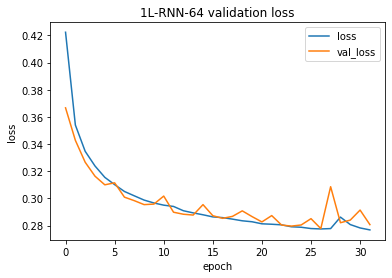

In [11]:
plt.plot(history_1L_RNN_64.history['loss'])
plt.plot(history_1L_RNN_64.history['val_loss'])
plt.title('1L-RNN-64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

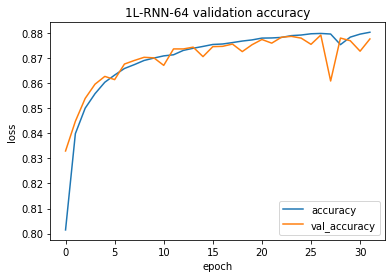

In [24]:
plt.plot(history_1L_RNN_64.history['accuracy'])
plt.plot(history_1L_RNN_64.history['val_accuracy'])
plt.title('1L-RNN-64 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [20]:
loss, acc = model.evaluate(X_train_indixes, Y_oh_train)
print()
print("Accurary on train set = ", acc)

loss, acc = model.evaluate(X_test_indixes, Y_oh_test)
print()
print("Accurary on test set = ", acc)

171060/171060 [==============================] - 1342s 8ms/step - loss: 0.2767 - accuracy: 0.8802

Accurary on train set =  0.8802411556243896
3125/3125 [==============================] - 23s 7ms/step - loss: 0.2860 - accuracy: 0.8762

Accurary on test set =  0.8762000203132629


# LSTM model

In [25]:
def Initial_model(input_shape, word_to_vec_map, word_to_index):

    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape = (input_shape), dtype = "int32")
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences = False))(embeddings)

    # Propagate X through a Dense layer into 2 units
    X = Dense(2, activation = "sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [26]:
model = Initial_model((X_test_indixes[0].shape), word_to_vec_map, word_to_index)
model.summary()

my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/1L-LSTM128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/1L-LSTM128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = opt)
history_1L_LSTM128 = model.fit(X_train_indixes, Y_oh_train, epochs = 50, batch_size = 8192, 
                                            validation_split =  0.02, shuffle=True, callbacks=my_callbacks)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 120,440,110
Trainable params: 439,810
Non-trainable params: 120,000,300
_________________________________________________________________
Epoch 1/50
655/655 [==============================] - 150s 229ms/step - loss: 0.3404 - accuracy: 0.8454 - val_loss: 0.2905 - val_accuracy: 0.8723
Epoch 2/50
655/655 [==============================] - 149s 228ms/step - loss: 0.2817 -

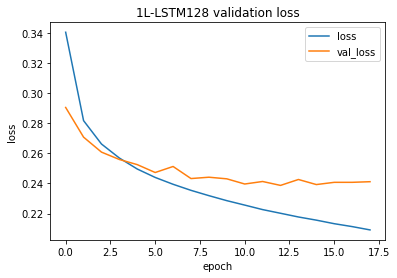

In [27]:
plt.plot(history_1L_LSTM128.history['loss'])
plt.plot(history_1L_LSTM128.history['val_loss'])
plt.title('1L-LSTM128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

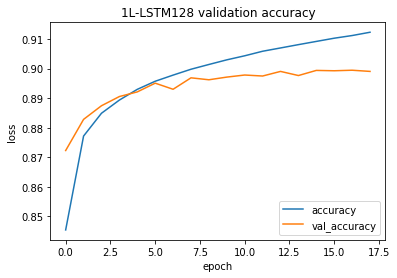

In [30]:
plt.plot(history_1L_LSTM128.history['accuracy'])
plt.plot(history_1L_LSTM128.history['val_accuracy'])
plt.title('1L-LSTM128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [31]:
loss, acc = model.evaluate(X_train_indixes, Y_oh_train)
print()
print("Accurary on train set = ", acc)

loss, acc = model.evaluate(X_test_indixes, Y_oh_test)
print()
print("Accurary on test set = ", acc)

171060/171060 [==============================] - 641s 4ms/step - loss: 0.2036 - accuracy: 0.9152

Accurary on train set =  0.9151943922042847
3125/3125 [==============================] - 12s 4ms/step - loss: 0.2432 - accuracy: 0.8970

Accurary on test set =  0.8970100283622742


# 2-layers 128/128 LSTM

In [32]:
def Initial_model(input_shape, word_to_vec_map, word_to_index):

    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape = (input_shape), dtype = "int32")
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences = True))(embeddings)
    
    # Propagate X through the Dropout layer with 0.3 Porp
    X = Dropout(rate = 0.3)(X)

    # Propagate X through the BatchNormalization layer
    X = BatchNormalization()(X)
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences = False))(X)
    
    # Propagate X through the Dropout layer with 0.3 Porp
    X = Dropout(rate = 0.3)(X)
    
    # Propagate X through a Dense layer into 2 units
    X = Dense(2, activation = "sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [33]:
model = Initial_model((X_test_indixes[0].shape), word_to_vec_map, word_to_index)
model.summary()

my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/2L-LSTM128_128",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/2L-LSTM128_128"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = opt)
history_2L_LSTM128_128 = model.fit(X_train_indixes, Y_oh_train, epochs = 50, batch_size = 8192, 
                                            validation_split =  0.02, shuffle=True, callbacks=my_callbacks)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

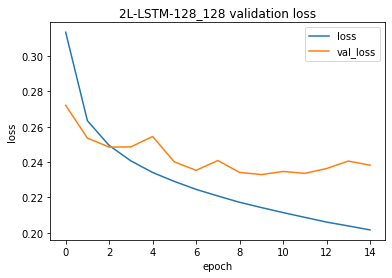

In [34]:
plt.plot(history_2L_LSTM128_128.history['loss'])
plt.plot(history_2L_LSTM128_128.history['val_loss'])
plt.title('2L-LSTM-128_128 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')

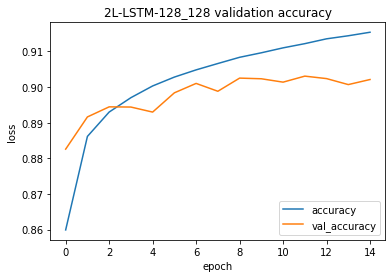

In [35]:
plt.plot(history_2L_LSTM128_128.history['accuracy'])
plt.plot(history_2L_LSTM128_128.history['val_accuracy'])
plt.title('2L-LSTM-128_128 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [9]:
loss, acc = model.evaluate(X_train_indixes, Y_oh_train)
print()
print("Accurary on train set = ", acc)

loss, acc = model.evaluate(X_test_indixes, Y_oh_test)
print()
print("Accurary on test set = ", acc)

171060/171060 [==============================] - 1068s 6ms/step - loss: 0.2025 - accuracy: 0.9147

Accurary on train set =  0.9146613478660583
3125/3125 [==============================] - 20s 6ms/step - loss: 0.2357 - accuracy: 0.9014

Accurary on test set =  0.901390016078949


# 3Layer LSTMs 128_128_64

In [10]:
def Initial_model(input_shape, word_to_vec_map, word_to_index):

    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape = (input_shape), dtype = "int32")
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences = True))(embeddings)
    
    # Propagate X through the Dropout layer with 0.3 Porp
    X = Dropout(rate = 0.3)(X)

    # Propagate X through the BatchNormalization layer
    X = BatchNormalization()(X)
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(LSTM(128, return_sequences = True))(X)
    
    # Propagate X through the Dropout layer with 0.3 Porp
    X = Dropout(rate = 0.3)(X)

    # Propagate X through the BatchNormalization layer
    X = BatchNormalization()(X)
    
    # Propagate the embeddings through the first bidirectional LSTM layer with 128 hiden unit each
    # The returned output is a batch of sequences.
    X = Bidirectional(LSTM(64, return_sequences = False))(X)
    
    # Propagate X through the Dropout layer with 0.3 Porp
    X = Dropout(rate = 0.3)(X)
    
    # Propagate X through a Dense layer into 2 units
    X = Dense(2, activation = "sigmoid")(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    return model

In [11]:
model = Initial_model((X_test_indixes[0].shape), word_to_vec_map, word_to_index)
model.summary()

my_callbacks = [callbacks.ModelCheckpoint(filepath="./Model_callback/models/3L-LSTM128_128_64",
                                          monitor='val_loss',
                                          mode='auto',
                                          save_best_only= True),
                callbacks.CSVLogger("./Model_callback/logger/32L-LSTM128_128_64"), 
                callbacks.EarlyStopping(monitor="val_loss",patience=5)]

opt = Adam() 
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = opt)
history_3L_LSTM128_128_64 = model.fit(X_train_indixes, Y_oh_train, epochs = 50, batch_size = 8192, 
                                            validation_split =  0.02, shuffle=True, callbacks=my_callbacks)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           120000300 
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           439296    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 256)           1024      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)          

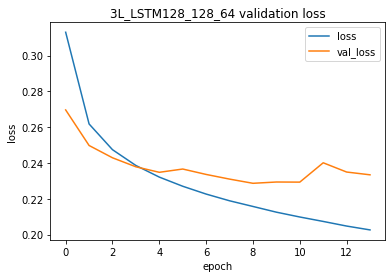

In [12]:
plt.plot(history_3L_LSTM128_128_64.history['loss'])
plt.plot(history_3L_LSTM128_128_64.history['val_loss'])
plt.title('3L_LSTM128_128_64 validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')

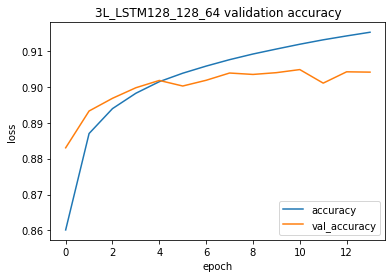

In [13]:
plt.plot(history_3L_LSTM128_128_64.history['accuracy'])
plt.plot(history_3L_LSTM128_128_64.history['val_accuracy'])
plt.title('3L_LSTM128_128_64 validation accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()

In [14]:
loss, acc = model.evaluate(X_train_indixes, Y_oh_train)
print()
print("Accurary on train set = ", acc)

loss, acc = model.evaluate(X_test_indixes, Y_oh_test)
print()
print("Accurary on test set = ", acc)

171060/171060 [==============================] - 1463s 9ms/step - loss: 0.1894 - accuracy: 0.9212

Accurary on train set =  0.9211581349372864
3125/3125 [==============================] - 27s 9ms/step - loss: 0.2354 - accuracy: 0.9032

Accurary on test set =  0.903219997882843
